# Modelling

## Introduction

In this notebook, I will explore the models and techniques in detail, and try to evaluate thier performances.  
I will also try to explain what each model is trying to do, and is it working for this case.  
The contents covered are:
1. [Baseline](#Baseline)
2. [Naive Bayes](#Naive-Bayes)
3. [Logistic Regression](#Logistic-Regression)
4. [Ensemble Methods](#Ensemble-Methods)  
    i. [RF](#RF)  
    ii. [XGB](#XGB)  
5. [Conclusions](#Conclusions)

In [1]:
import joblib
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import re

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction import text 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression

from scipy.stats import shapiro, uniform, randint

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
df = pd.read_csv('../data/combined_df.csv')

In [3]:
df.head()

,id,title,post_content,user,label,title_word_count,title_len,post_word_count,post_len,emoji_num,emoji_post
0,119r7rg,THROWDOWN THURSDAY: LEAKS CONFIRM LINK IS IN T...,"WELCOME TO THROWDOWN THURSDAY, TURN YOUR CAPS ...",1338h4x,1,11,65,114,674,0,0
1,11c6ol7,"smile sunday - happy 30th anniversary, star fox!",turn your caps lock off and rave about whateve...,tale-wind,1,8,48,231,1515,0,0
2,11cai3l,Never played a Pokémon game- where do I start?,I’ve been a gamer since early Gameboy days but...,Focusboy50,1,9,46,60,320,0,0
3,11bipdi,Universal Brazil posted a video of a Mario mov...,NaN,Nas160,1,21,114,0,0,0,0
4,11bkknf,MyNintendo offering eight exclusive reversible...,NaN,blubberpuppers,1,20,139,0,0,0,0


In [4]:
df.groupby('label').count()

,id,title,post_content,user,title_word_count,title_len,post_word_count,post_len,emoji_num,emoji_post
label,,,,,,,,,,
0,1988,1988,679,1926,1988,1988,1988,1988,1988,1988
1,1916,1916,645,1799,1916,1916,1916,1916,1916,1916


## Baseline

The most base case prediction should be as follows:  
1. I look at the entire dataset and see how it is split into ninetendo and playstation.  
2. I make a guess everytime based on how many posts are from nintendo and how many posts are from play station.

I have 1988 posts from playstation.  
I have 1916 posts from ninetendo.  
I make a random number selector that simply selects 1 or 0, based on occurance of playstation and nintendo.  
(If I am to fit the entire data set to training.)

In [5]:
class BaseLineModel(object):
    '''base line model
    '''
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.rand_train()
    def rand_train(self):
        # becasue true = 1, so sum(true)/len(total) == occurance probability
        self.prob = sum(self.y)/len(self.y)
    def predict(self, X_pred,random_state = 42):
        # predict based on probability
        if random_state:
            np.random.seed(42)
        prob_0 = 1-self.prob
        prob_1 = self.prob
        pred = []
        for i in range(len(X_pred)):
            pred.append(np.random.choice([0, 1], p=[prob_0, prob_1]))
        return pred

In [6]:
def print_confusion_matrix(y_actual, y_pred):
    cf_matrix = confusion_matrix(y_actual, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [7]:
def metrics_for_model(y_true, y_pred):
    '''find the relavent metrics from confusion metrics
    arg:
        y_true: true value for y
        y_pred: predicted value for y
    out:
        pre: precison score
        rec: recall score
        f1: f1 socre
    '''
    tn, fp, fn, tp =confusion_matrix(y_true, y_pred).ravel()
    acc = (tp+tn)/(tp+fp+tn+fn)
    pre = tp/(tp+fp)
    sp = tn/(tn+fp)
    rec = tp/(tp+fn)
    f1 = 2*(pre*rec)/(pre+rec)
    print(f"The accuracy of this inference is: {acc}")
    print(f"The precision of this inference is: {pre}")
    print(f"The specificty of this inference is: {sp}")
    print(f"The recall of this inference is: {rec}")
    print(f"The f1 score for this inference is: {f1}")
    return pre, rec, f1

In [8]:
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['label'], test_size=0.2, random_state=42)

In [9]:
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [10]:
base_line = BaseLineModel(X_train, y_train)
y_pred_base = base_line.predict(X_test)

The accuracy of this inference is: 0.528809218950064
The precision of this inference is: 0.5406824146981627
The specificty of this inference is: 0.5418848167539267
The recall of this inference is: 0.5162907268170426
The f1 score for this inference is: 0.5282051282051281


(0.5406824146981627, 0.5162907268170426, 0.5282051282051281)

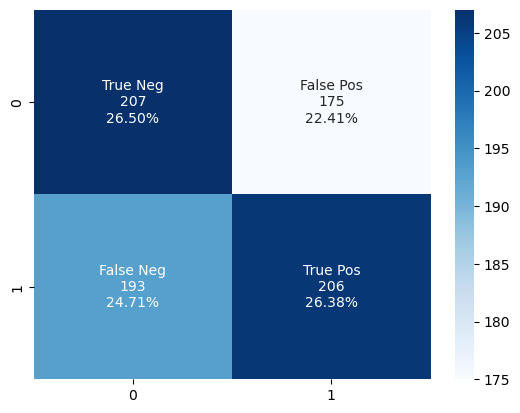

In [11]:
print_confusion_matrix(y_test, y_pred_base);
metrics_for_model(y_test, y_pred_base)

This is the my baseline model.  
It is equally bad at predicting both, and have a very even mixture for errors too!  
The main evalution metric is my coonfusion matrix.  
This is becasue confusion matrix provide the most complete information to my classification model.  
From it, my accuracy, recall, precision, specificty, f1 all can be calculated.  
What I am focusing on, is the f1 score.  
I want my model to be good for both predicting precisely (tp/tp+fp) and with good recall (tp/tp+fn).  
F1 score can also be described as the harmonic mean or weighted average of precision and recall.  
With my baseline model established, I will go on to investigate with other methods!

## Naive Bayes

I am using multinominal NB as explained in the EDA notebook.  
It is a simple classification model and commonly used in NLP tasks like that one at hand.  
I will examine some techniques and how they affect the model.  
1. Extracting words from web links.
2. Stemming
3. Lemmatization  

Then the preprocessed tokens will be sent to TF-IDF.  
After which, it will be fitted using NB.
I will then examine the model and decide which variant of the model to use, should I want a NB model for production.

In [12]:
# Import my stop words
with open('../data/stopwords.pkl', 'rb') as f:
    my_stop_words = pickle.load(f)

In [13]:
class StemLemmatizeTransformer(BaseEstimator, TransformerMixin):
    '''Class that 
    1. extract words from url
    2. stem words
    3. lemmatize words
    '''
    def __init__(self):
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        stemmed_lemmatized_text = []
        replace_list = ['apps.', 'http://', 'https://', 'www.', '.net', '.com', '/', '.', '-']
        for i, text in enumerate(X):
            for part in replace_list:
                text = text.replace(part, ' ')
            # X[i] = text
            stemmed_words = [self.stemmer.stem(word) for word in text.split()]
            stemmed_lemmatized_text.append(' '.join([self.lemmatizer.lemmatize(word) for word in stemmed_words]))
        return stemmed_lemmatized_text

In [14]:
final_nb_pipeline = Pipeline([
    ('stem_lemmatize', StemLemmatizeTransformer()),
    ('tfidf', TfidfVectorizer(min_df=5, ngram_range=(1,3), stop_words=my_stop_words)),
    ('clf', MultinomialNB()),
])


In [15]:
final_nb_model = final_nb_pipeline.fit(X_train, y_train)

In [16]:
y_pred_nb = final_nb_model.predict(X_test)

The accuracy of this inference is: 0.8796414852752881
The precision of this inference is: 0.9066666666666666
The specificty of this inference is: 0.9083769633507853
The recall of this inference is: 0.8521303258145363
The f1 score for this inference is: 0.8785529715762274


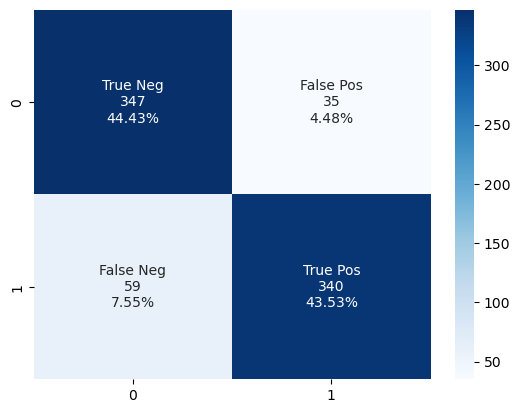

In [17]:
print_confusion_matrix(y_test, y_pred_nb)
metrics_for_model(y_test, y_pred_nb);

In [18]:
df_comb = pd.concat([X_test, y_test, pd.DataFrame(y_pred_nb, columns=['y_pred_nb'])], axis=1)
df_comb.loc[df_comb['label'] != df_comb['y_pred_nb']]

,title,label,y_pred_nb
4,It’s weird how Sakurai is the only “employee” ...,1,0
34,PSA: If you're having issues with your Switch ...,1,0
41,WARNING DON'T Upload photos on nintendo live chat,1,0
53,Every Issue of Nintendo Power uploaded to arch...,1,0
60,Theogony of Hyrule: The Tale of the Goddess Hy...,1,0
...,...,...,...
746,Next EU Splatfest: Should the toilet roll hang...,1,0
747,Tis the season on the Starfall Islands. You ca...,1,0
749,"As a kid, Nintendo helped me earn my Bear Badge.",1,0
766,Galar Region is based off the UK. Victorian-es...,1,0


The accuracy of this inference is: 0.8860435339308579
The precision of this inference is: 0.9078947368421053
The specificty of this inference is: 0.9083769633507853
The recall of this inference is: 0.8646616541353384
The f1 score for this inference is: 0.8857509627727858


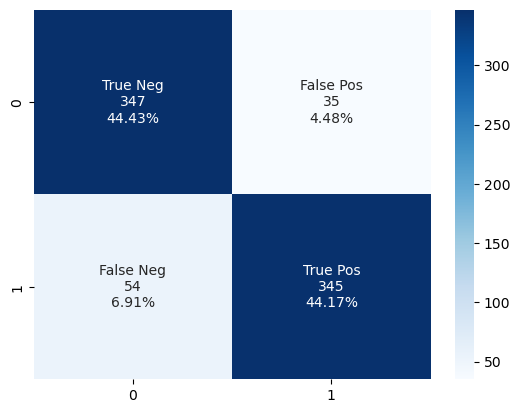

In [19]:
# compare it with my prelim model without the removal of key words
prelim_nb_model = joblib.load('../model/prelim_model.joblib')
y_pred_prelim_nb = prelim_nb_model.predict(X_test)
print_confusion_matrix(y_test, y_pred_prelim_nb)
metrics_for_model(y_test, y_pred_prelim_nb);

In [20]:
df_comb = pd.concat([df_comb, pd.DataFrame(y_pred_prelim_nb, columns=['y_prelim_nb'])], axis=1)
df_comb.loc[df_comb['label'] != df_comb['y_prelim_nb']]

,title,label,y_pred_nb,y_prelim_nb
4,It’s weird how Sakurai is the only “employee” ...,1,0,0
7,Spider Man trailer with 90s theme,0,0,1
52,"If Nintendo could give you one ""gift,"" as in a...",1,1,0
53,Every Issue of Nintendo Power uploaded to arch...,1,0,0
54,PSA for those looking at the legend of dragoon...,0,0,1
...,...,...,...,...
747,Tis the season on the Starfall Islands. You ca...,1,0,0
748,Nintendo's next console will lean towards stre...,1,1,0
749,"As a kid, Nintendo helped me earn my Bear Badge.",1,0,0
762,You can't convert replays to video unless you ...,1,1,0


Unfortunately, the performance is very slightly worse than my preliminary model with key give away words removed.    
Comparing my model in EDA notebook with removal of the stop words, this current 'final' model have a slightly lower `true positive` count, and a slightly `higher flase negative`.  

---
What this means is that my combination of stemming and lemmatization and N-grams makes no major improvement to the model.  
If fact, they might have tightened the 'bound' the model used to determine a post title as `true positive`.  
It is more difficult to be passsed as a title from `ninetendo` post.   
This is very likely due to the inclusion of stemming and lemmatization.  
Stemming is a more aggressive technique where words are truncated to their root form, whereas lemmatization is a more precise technique that considers the context of the word and reduces it to its base form.
Combining both techniques, I am reducing the size of the vocabulary, and hoping it will increase the accuracy of the model.   
However, in this case it did not achieve what I hope it can achieve.  
This could be due to stemming removing too much of a word.  
Let me do an experiment to confirm a few things:
1. it is becasue of stemming and lemmatization.
2. it is mainly due to stemming. 
3. TFIDF using N-grams does not impact this use case much.

In [21]:
# Build a pipeline without the stemming and lemmatization.
final_nb_pipeline_2 = Pipeline([
    # ('stem_lemmatize', StemLemmatizeTransformer()),
    ('tfidf', TfidfVectorizer(min_df=5, ngram_range=(1,3), stop_words=my_stop_words)),
    ('clf', MultinomialNB()),
])

The accuracy of this inference is: 0.8886043533930857
The precision of this inference is: 0.9216216216216216
The specificty of this inference is: 0.9240837696335078
The recall of this inference is: 0.8546365914786967
The f1 score for this inference is: 0.8868660598179453


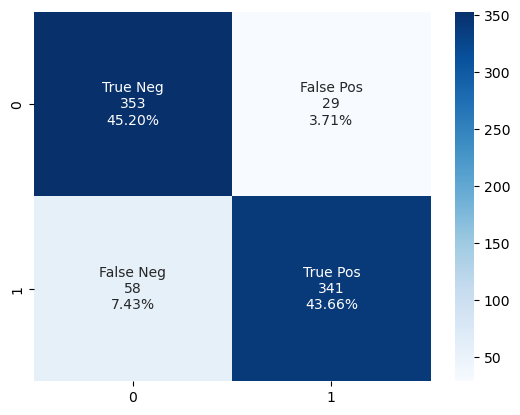

In [22]:
final_nb_pipeline_2.fit(X_train, y_train)
y_pred_nb_2 = final_nb_pipeline_2.predict(X_test)
print_confusion_matrix(y_test, y_pred_nb_2)
metrics_for_model(y_test, y_pred_nb_2);

Yes! As I have hypothesised, the stemming and lemmatization actually decreased the performance of the model.  
How the above model is different from my EDA model is that, this model uses n-grams.  
N-grams takes N words/ tokens in a document and use them as feature.   
N-grams during the tokenisation process helps to retain some information on the context of the words.  
Indeed, with n-grams the `true nrgatives` have a better performance as the `false positive` decreases.   
However, the performance improvement is not too much.   
This also serve as a proof to my third hypothesis, inclusion of n-grams, or at least up to trigram, doesn't drastically increase the performance of the model in this case.   
Also, if I decrease the minimum document frequency `min_df`, it will result in a better performance in this case.  
However, since I still want to keep my model more generalised, I feel that a small drop in performance is reasonable.  
Therefore, I am still keeping `min_df = 5`.

In [23]:
df_comb = pd.concat([df_comb, pd.DataFrame(y_pred_nb_2, columns=['y_pred_nb_2'])], axis=1)
df_comb.loc[df_comb['label'] != df_comb['y_pred_nb_2']]

,title,label,y_pred_nb,y_prelim_nb,y_pred_nb_2
4,It’s weird how Sakurai is the only “employee” ...,1,0,0,0
53,Every Issue of Nintendo Power uploaded to arch...,1,0,0,0
69,You can buy a brand new sealed copy of LarryBo...,1,0,0,0
77,How simple texture compression can start a 20-...,1,0,0,0
79,Been online friends since Destiny launch in 20...,0,1,1,1
...,...,...,...,...,...
747,Tis the season on the Starfall Islands. You ca...,1,0,0,0
748,Nintendo's next console will lean towards stre...,1,1,0,0
749,"As a kid, Nintendo helped me earn my Bear Badge.",1,0,0,0
762,You can't convert replays to video unless you ...,1,1,0,0


Just by looking at the results of what went wrong, some very consistent mistakes can be found here.  
Like theese lines:   
`It’s weird how Sakurai is the only “employee” ...`,   
`Adding a search by publisher/maker`,   
`Do you think the Xenoblade Chronicles games wo...`  
These are the sentences that may not be covered by the traning set.    
I can try to keep updating my dataset.  


---
Now, time to check my 2nd hypothesis.   
Check is the problem due to stemming or lemmatization.  
That process is a bit mundane (edititng the 3 parts that forms my StemLemmatizeTransformer class) and I shall skip the process here.   
Let me just get stright to the results.  
I have tried 4 things in total for this part.  
1. No breaking down weblink.
2. No stemming.
3. No lemmatization.
4. No stemming and lemmatization.  
Here are the results.   

### No breaking web links
<img src='../img/remove_link_stripe.png' width="400" height="400"></img>
### No stemming
<img src='../img/no_stem.png' width="400" height="400"></img>
### No lemmatization
<img src='../img/no_lemma.png' width="400" height="400"></img>
### No stemming & lemmatization
<img src='../img/no_stem_n_lemma.png' width="400" height="400"></img>

Now, it should be obvious that both stemming and lemmatizition helpped to generalise the model...  
At the cost of a few `True Negatives`.  
Breaking the weblink or not, doesn't really matter.  
This could be because I dont have weblink in my test data?  
Anyways, via the experiments I have done, it doesn't really matter.  
Therefore, the final Multinominal Naive Bayes model/ pipeline I will use is my `final_nb_pipeline_2`.  
By having minmum document frequency of 5, and using n-grams from 1 to 3, I am able to achieve a relatively light weight, yet accurate model with good performance.  

The accuracy of this inference is: 0.9285943003522255
The precision of this inference is: 0.9621428571428572
The specificty of this inference is: 0.9669987546699875
The recall of this inference is: 0.8879367172050099
The f1 score for this inference is: 0.923551594103531


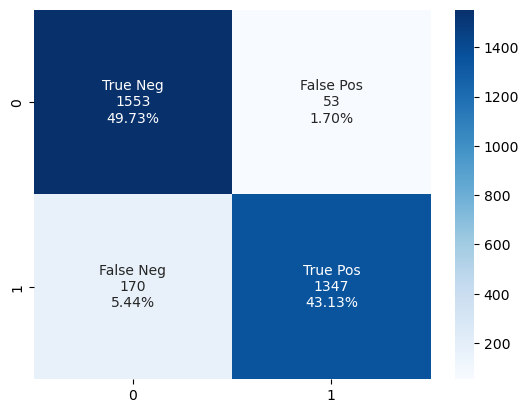

In [24]:
y_pred_nb_train = final_nb_pipeline_2.predict(X_train)
print_confusion_matrix(y_train, y_pred_nb_train)
metrics_for_model(y_train, y_pred_nb_train);

Also, looking at the predictions on the training set, and comparing it against the predictions on the testing set, the percentage of true positive is quite similar.  
All other metrics are slightly higher for the training data set.  
However, it is only slightly higher, at about 0.04, comparing training and test.  
This means that while the fitted model is slightly over fitted, it is still quite reasonable. 

---
Since my goal is to accurately predict the origin of my post title, the selected pipeline, `final_nb_pipeline_2`, offering a f1-score of 0.8886, is suitable for this job.  
Reason is that it is a good model with good f1 score and doesn't seem too over fitted.

## Logistic Regression

Logistic Regression is a linear model.  
It is simple, but very powerful.  
Although the actual logit values may not make sense, but it is a good predictor.   
It is also very explainable, similar to other forms of linear regression models.   
The formulation for logistic regression is as follows:  
P(y=1|X) = 1 / (1 + exp(-(β0 + β1X1 + β2X2 + ... + βkXk)))  
Where:

- P(y=1|X) is the probability of the outcome variable (y) being equal to 1, given the predictor variables (X)   
- β0, β1, β2, ..., βk are the coefficients of the model, representing the effect of each predictor variable on the log odds of the outcome variable   
- X1, X2, ..., Xk are the values of the predictor variables   

To interpret the coefficients of the logistic regression model, we can look at their exponentiated values, known as odds ratios.   
The odds ratio represents the change in the odds of the outcome variable for a one-unit increase in the predictor variable, holding all other predictor variables constant.  
For example, if the coefficient of a predictor variable is 0.5, the odds ratio would be exp(0.5) = 1.65.   
This means that for a one-unit increase in the predictor variable, the odds of the outcome variable increase by a factor of 1.65, holding all other predictor variables constant.    
If the odds ratio is greater than 1, the predictor variable has a positive effect on the outcome variable.    
If the odds ratio is less than 1, the predictor variable has a negative effect on the outcome variable.    
If the odds ratio is equal to 1, the predictor variable has no effect on the outcome variable.   

In [25]:
log_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5, ngram_range=(1,3), stop_words=my_stop_words)),
    ('logistic', LogisticRegression()),
])

In [26]:
log_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 3),
                                 stop_words={'a', 'about', 'above', 'across',
                                             'after', 'afterwards', 'again',
                                             'against', 'ain', 'all', 'almost',
                                             'alone', 'along', 'already',
                                             'also', 'although', 'always', 'am',
                                             'among', 'amongst', 'amoungst',
                                             'amount', 'an', 'and', 'another',
                                             'any', 'anyhow', 'anyone',
                                             'anything', 'anyway', ...})),
                ('logistic', LogisticRegression())])

The accuracy of this inference is: 0.8950064020486556
The precision of this inference is: 0.9390581717451524
The specificty of this inference is: 0.9424083769633508
The recall of this inference is: 0.849624060150376
The f1 score for this inference is: 0.8921052631578947


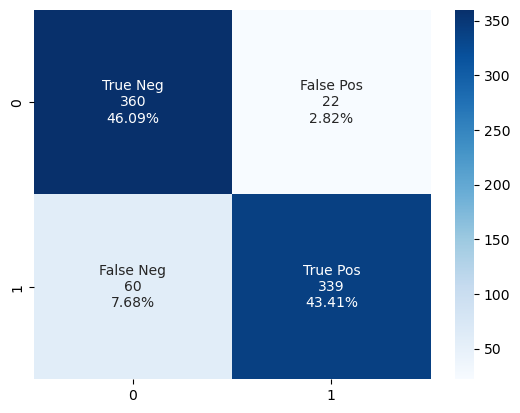

In [27]:
y_pred_log = log_pipeline.predict(X_test)
print_confusion_matrix(y_test, y_pred_log)
metrics_for_model(y_test, y_pred_log);

Logistic regression gives exceptional results!  
My guess is that the nature of the data being word tokens helps tremendously in this context.  
Each token plays a part in deciding if the word comes from one source or another!  

In [28]:
df_comb = pd.concat([df_comb, pd.DataFrame(y_pred_log, columns=['y_pred_log'])], axis=1)
df_comb.loc[df_comb['label'] != df_comb['y_pred_log']]

,title,label,y_pred_nb,y_prelim_nb,y_pred_nb_2,y_pred_log
4,It’s weird how Sakurai is the only “employee” ...,1,0,0,0,0
54,PSA for those looking at the legend of dragoon...,0,0,1,0,1
69,You can buy a brand new sealed copy of LarryBo...,1,0,0,0,0
77,How simple texture compression can start a 20-...,1,0,0,0,0
79,Been online friends since Destiny launch in 20...,0,1,1,1,1
...,...,...,...,...,...,...
748,Nintendo's next console will lean towards stre...,1,1,0,0,0
749,"As a kid, Nintendo helped me earn my Bear Badge.",1,0,0,0,0
762,You can't convert replays to video unless you ...,1,1,0,0,0
766,Galar Region is based off the UK. Victorian-es...,1,0,1,1,0


In [29]:
coefficients = log_pipeline[1].coef_[0]

In [30]:
coef_names = log_pipeline[0].get_feature_names_out()

In [33]:
log_coeff_dict = {"log_coef": [], "coef_name":[], "exp_coef":[]}
for coef, name in zip(coefficients, coef_names):
    log_coeff_dict['log_coef'].append(coef)
    log_coeff_dict['coef_name'].append(name)
    log_coeff_dict['exp_coef'].append(np.exp(coef))

In [34]:
# Make dictionary to pandas dataframe
log_coef_explained = pd.DataFrame(log_coeff_dict)
log_coef_explained.sort_values(by='exp_coef',ascending=False)

,log_coef,coef_name,exp_coef
837,6.501446,switch,666.103805
503,4.851615,mario,127.946869
390,3.284914,history,26.706688
939,3.194616,wii,24.400795
632,3.080390,pokemon,21.766896
...,...,...,...
385,-1.876695,help,0.153095
676,-2.094873,psvr2,0.123086
660,-2.806486,ps,0.060417
667,-2.821731,ps4,0.059503


Now, the exponential of coefficient is the odds ratio.   
This means, with every increase appearance of the word in text, the increase in likely hood of the title being from `nintendo` is given by the odds ratio, or the `exp_coef` in this case.   
So, with one word like switch in title, it is almost 666 more times to be from `nintendo` compared to a sentence with the exact same content but with out the word `switch`.    
The most give away key word for `nintendo` is none other than `switch`.  
The most give away key word for `playstation` is none other than `ps5`.  
Now, I have knowledge on exactly this model predicts!  
I can even fool the model by making a totally `playstation` post and include a `switch` to turn the answer around!  
Also, it seems that the `playstation` users needed a lot of help.

The accuracy of this inference is: 0.9426833173230867
The precision of this inference is: 0.9764957264957265
The specificty of this inference is: 0.9794520547945206
The recall of this inference is: 0.9037574159525379
The f1 score for this inference is: 0.9387196165696678


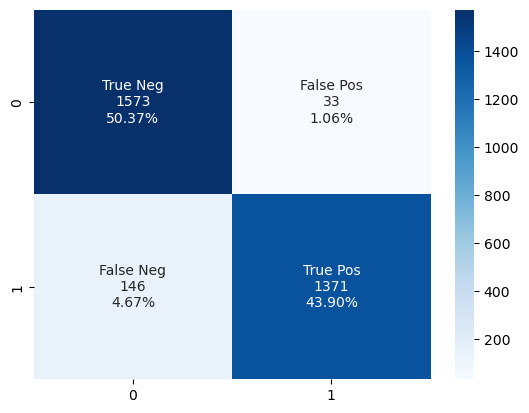

In [35]:
y_pred_log_train = log_pipeline.predict(X_train)
print_confusion_matrix(y_train, y_pred_log_train)
metrics_for_model(y_train, y_pred_log_train);

The logistic regression model performed really very well!  
Looking through the metrics, it did a fantansic job predicting where the post title originates from.  
This is probably thanks to the corpus having a clear disctinction between them in the first place.  
Nonetheless, it is a quick, easy to interpret and simple model that does a fantanstic job.  
The over fitting is not very bad too. 

## Ensemble Methods

Ensemble methods are ML techniques that helps to improve accuracy by combining multiple models, instead of just using a single model.  
The three most common methods under ensemble are:  
1. Bagging (Bootstrap aggregating)
2. Boosting (Converting multiple weak learners into a single strong learning model)
3. Stacking (Combining different models to best answer the question)  

Bagging is random sampling with replacement from the available training data and make an estimator with each bootstrapped dataset, same model trained on the same dataset.  
Boosting is making a series of weak learners that learns to avoid the mistake made by the previous one, or sequence of models that correct the predictions of prior models.
Stacking is having a model that combines 2 or more models that each have thier individual strengths, different level 0 models trained on same dataset combined by a level 1 model.   

I will explore:
1. [RF](#RF)
2. [XGB](#XGB)

Stacking will not be explored here.

### RF

RF or Random Forest is a famous bagging method.  
In this notebook, I will try to use the Random Forest Classifier.  
RF is a method where many weak learners, or models that doesn't perform so well, is built by over sampling of the training dataset.  
In other words, many samples were taken from the same dataset with replacement, and each sample is used to build a model that doesn't work perfectly.  
Then the results from the numerous models built are aggregated to make a final decision.  
The process of creating these smaller decision trees involves a technique called bootstrap aggregation, also known as bagging.   
This means that each tree is built using a randomly sampled subset of the training data, which helps to reduce overfitting and improve the accuracy of the model.  
For the sklearn implementation, the default splitting uses a measure of impurity, called the Gini index, to split each tree.   
The Gini index is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it were randomly labeled according to the distribution of labels in the subset.   
The Gini index is used to evaluate the quality of each split in the decision tree, and the algorithm chooses the split that results in the greatest reduction in impurity.   
Gini index is very closely related to entropy, which is the average surprise on would expect, or the sum of specific values for surprise multiplied by the probability of observing that specific value for surprise.  
For a very detailed expliannation, youc can check out this video by Josh Starmer, on [entropy for data scientists](https://www.youtube.com/watch?v=YtebGVx-Fxw&ab_channel=StatQuestwithJoshStarmer).   
Random Forest works because it leverages the power of multiple decision trees to create a more accurate model than any single decision tree could achieve alone.    
By randomly sampling the training data and using different subsets to train each decision tree, it reduces overfitting and increases the model's ability to generalize to new data.    
Additionally, by selecting the features used to split each tree randomly, it reduces the correlation between trees and helps to capture different aspects of the data, leading to a more diverse set of predictions.     
Overall, this results in a robust and accurate model that can be used for a variety of classification and regression tasks.

In [36]:
RF_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5, ngram_range=(1,3), stop_words=my_stop_words)),
    # ('cvec', CountVectorizer(min_df=5, ngram_range=(1,3), stop_words=my_stop_words)),
    ('RF', RandomForestClassifier(
        n_estimators=500, 
        max_depth=250, 
        min_samples_split=2, 
        min_samples_leaf=1,
        random_state=42
    )),
])

In [37]:
RF_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 3),
                                 stop_words={'a', 'about', 'above', 'across',
                                             'after', 'afterwards', 'again',
                                             'against', 'ain', 'all', 'almost',
                                             'alone', 'along', 'already',
                                             'also', 'although', 'always', 'am',
                                             'among', 'amongst', 'amoungst',
                                             'amount', 'an', 'and', 'another',
                                             'any', 'anyhow', 'anyone',
                                             'anything', 'anyway', ...})),
                ('RF',
                 RandomForestClassifier(max_depth=250, n_estimators=500,
                                        random_state=42))])

The accuracy of this inference is: 0.8783610755441741
The precision of this inference is: 0.9130434782608695
The specificty of this inference is: 0.9162303664921466
The recall of this inference is: 0.8421052631578947
The f1 score for this inference is: 0.8761408083441982


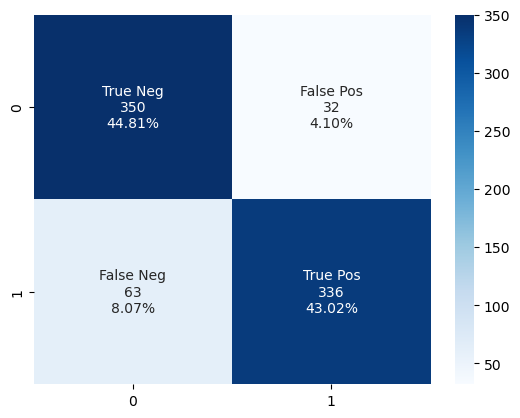

In [38]:
y_pred_RF = RF_pipeline.predict(X_test)
print_confusion_matrix(y_test, y_pred_RF)
metrics_for_model(y_test, y_pred_RF);

In [39]:
df_comb = pd.concat([df_comb, pd.DataFrame(y_pred_RF, columns=['y_pred_RF'])], axis=1)
df_comb.loc[df_comb['label'] != df_comb['y_pred_RF']]

,title,label,y_pred_nb,y_prelim_nb,y_pred_nb_2,y_pred_log,y_pred_RF
4,It’s weird how Sakurai is the only “employee” ...,1,0,0,0,0,0
7,Spider Man trailer with 90s theme,0,0,1,0,0,1
41,WARNING DON'T Upload photos on nintendo live chat,1,0,1,1,1,0
47,GoldenEye really knocked down the competition ...,1,1,1,1,1,0
54,PSA for those looking at the legend of dragoon...,0,0,1,0,1,1
...,...,...,...,...,...,...,...
747,Tis the season on the Starfall Islands. You ca...,1,0,0,0,0,0
748,Nintendo's next console will lean towards stre...,1,1,0,0,0,0
749,"As a kid, Nintendo helped me earn my Bear Badge.",1,0,0,0,0,0
766,Galar Region is based off the UK. Victorian-es...,1,0,1,1,0,0


Machine learning is not magic.   
It is math and statistics, based on data.  
Some problem that can't be solved using simpler models, can't be solved by RF as well.  
For example:   
line 77: `How simple texture compression can start a 20-...`  
line 79: `Been online friends since Destiny launch in 20...`  
line 747: `Tis the season on the Starfall Islands. You ca...`  
line 769: `Japan Is More Excited About Nintendo Labo Than...`  
Some of thses problems can be solved by allowing `nintendo` and `playstation` in the document.  
Also, lowering the minimum document frequency always helps.  

In [40]:
RF_params = {'n_estimators':[100, 200, 300, 400, 500], 
             'max_depth':[100, 150, 200, 250], 
             'min_samples_split':[6, 4 ,2], 
             'min_samples_leaf':[3,2,1],
            }

In [41]:
grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid=RF_params,
                           cv=5,
                           )

rf_grid_search_CV = Pipeline(
    steps=[('tfidf', TfidfVectorizer(min_df=5, ngram_range=(1,3), stop_words=my_stop_words)), 
           ("RF Grid Search", grid_search)]
) 

In this case, the X_train is further split into 5 sets and used to train and fit the model.  
The line below examines a total of 900 fits.  
It can take a long time.

In [31]:
rf_grid_search_CV.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 3),
                                 stop_words={'a', 'about', 'above', 'across',
                                             'after', 'afterwards', 'again',
                                             'against', 'ain', 'all', 'almost',
                                             'alone', 'along', 'already',
                                             'also', 'although', 'always', 'am',
                                             'among', 'amongst', 'amoungst',
                                             'amount', 'an', 'and', 'another',
                                             'any', 'anyhow', 'anyone',
                                             'anything', 'anyway', ...})),
                ('RF Grid Search',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(random_state=42),
                              param_grid={'max_depth': [100, 150, 200, 250],
                                          'min_samples_leaf': [3, 2, 1],
                                          'min_samples_split': [6, 4, 2],
                                          'n_estimators': [100, 200, 300, 400,
                                                           500]}))])

In [32]:
print("Best scores: ", rf_grid_search_CV[1].best_score_)

Best scores:  0.8888876923076923


In [33]:
print("Best parameters: ", rf_grid_search_CV[1].best_params_)

Best parameters:  {'max_depth': 150, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [42]:
# Train a model using the parameters above.
RF_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5, ngram_range=(1,3), stop_words=my_stop_words)),
    # ('cvec', CountVectorizer(min_df=5, ngram_range=(1,3), stop_words=my_stop_words)),
    ('RF', RandomForestClassifier(
        n_estimators=300, 
        max_depth=250, 
        min_samples_split=4, 
        min_samples_leaf=1,
    )),
])

The accuracy of this inference is: 0.8860435339308579
The precision of this inference is: 0.9144385026737968
The specificty of this inference is: 0.9162303664921466
The recall of this inference is: 0.8571428571428571
The f1 score for this inference is: 0.8848641655886158


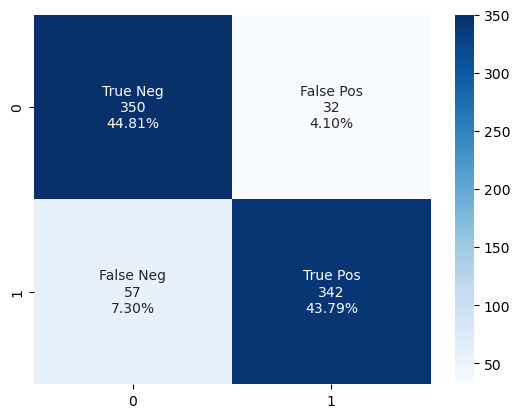

In [43]:
RF_pipeline.fit(X_train, y_train)
y_RF_pred_final = RF_pipeline.predict(X_test)
print_confusion_matrix(y_test, y_RF_pred_final)
metrics_for_model(y_test, y_RF_pred_final);

In [44]:
df_comb = pd.concat([df_comb, pd.DataFrame(y_RF_pred_final, columns=['y_RF_final'])], axis=1)
df_comb.loc[df_comb['label'] != df_comb['y_RF_final']]

,title,label,y_pred_nb,y_prelim_nb,y_pred_nb_2,y_pred_log,y_pred_RF,y_RF_final
7,Spider Man trailer with 90s theme,0,0,1,0,0,1,1
41,WARNING DON'T Upload photos on nintendo live chat,1,0,1,1,1,0,0
54,PSA for those looking at the legend of dragoon...,0,0,1,0,1,1,1
77,How simple texture compression can start a 20-...,1,0,0,0,0,0,0
79,Been online friends since Destiny launch in 20...,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
747,Tis the season on the Starfall Islands. You ca...,1,0,0,0,0,0,0
748,Nintendo's next console will lean towards stre...,1,1,0,0,0,0,0
749,"As a kid, Nintendo helped me earn my Bear Badge.",1,0,0,0,0,0,0
766,Galar Region is based off the UK. Victorian-es...,1,0,1,1,0,0,0


Looking at RF, very similar problems can be seen here...   
For example, key words like `nintendo` could not be recongnised for index 41, 748 and 769.  
This then leads the model to give predict whats from nintendo to be from playstation and vice versa.  
Other false predictions can likely be attributed to not having a clear context.  

The accuracy of this inference is: 0.9846301633045149
The precision of this inference is: 0.9946127946127946
The specificty of this inference is: 0.9950186799501868
The recall of this inference is: 0.97363216875412
The f1 score for this inference is: 0.9840106595602932


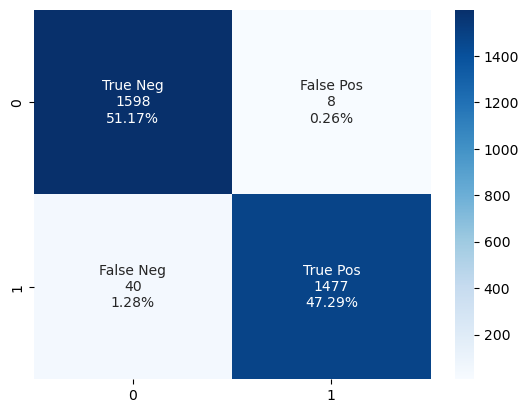

In [45]:
# check for over fitting
y_final_RF_pred_train = RF_pipeline.predict(X_train)
print_confusion_matrix(y_train, y_final_RF_pred_train)
metrics_for_model(y_train, y_final_RF_pred_train);

The final model is not fantanstic, in terms of all the socres.  
It also displayed some degree of over fitting, when comparing the training and testing sets.  
However, looking at the difference is likely due to the difference in the corpus used by training and testing sets.  
Also, the model with hyper parameters before cross validation performed better than model using hyper parameters after cross validation.  
The training set uses cross validation within the traning corpus.  
Hyper parameters are being tuned for the traning sets, not the testing set.  
This obviously doesn't generalise to the testing set.  
This actually reflects that more data should be gathered to enlarge the corpus.  
It also suggests that I may not want to remove the key give away words by putting them in the stop words list.  

---
Even so, the testing dataset performed okay with this model.  
It performed very similarly to navie bayes.  
I personally feel that this is an acceptable model.  

### XGB

Gradient boosting is a powerful machine learning technique used for both regression and classification tasks.    
It involves combining several weak models, typically decision trees, to create a strong predictive model.    
The idea behind gradient boosting is to iteratively improve upon the performance of a base model by adding new models to the ensemble that can compensate for the errors made by the previous models.

Extreme Gradient Boosting (XGBoost) is a popular implementation of gradient boosting that has gained significant popularity in recent years.    
XGBoost is an optimized version of the gradient boosting algorithm that uses a combination of techniques to improve performance and reduce computation time.
One of the key features of XGBoost is the use of a specialized gradient descent algorithm called "tree boosting" that constructs decision trees sequentially.    
Each new tree is trained to predict the residual errors of the previous trees, which allows the model to progressively improve its performance.
Another key feature of XGBoost is the use of regularization techniques such as L1 (lasso) and L2 (ridge) regularization, which help to prevent overfitting and improve the generalization performance of the model.   
XGBoost also uses a technique called "pruning," which involves removing parts of the tree that do not contribute to the overall accuracy of the model, reducing the model's complexity.
Finally, XGBoost is designed to handle large datasets and is optimized to take advantage of distributed computing environments.    
This makes it a powerful tool for training models on large-scale datasets.

In summary, XGBoost is an optimized implementation of the gradient boosting algorithm that can achieve state-of-the-art performance on a wide range of tasks.  

In [46]:
XGB_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5, ngram_range=(1,3), stop_words=my_stop_words)),
    # ('cvec', CountVectorizer(min_df=5, ngram_range=(1,3), stop_words=my_stop_words)),
    ('XGBoost', xgb.XGBClassifier(objective="binary:logistic", random_state=42)),
])

In [47]:
XGB_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 3),
                                 stop_words={'a', 'about', 'above', 'across',
                                             'after', 'afterwards', 'again',
                                             'against', 'ain', 'all', 'almost',
                                             'alone', 'along', 'already',
                                             'also', 'although', 'always', 'am',
                                             'among', 'amongst', 'amoungst',
                                             'amount', 'an', 'and', 'another',
                                             'any', 'anyhow', 'anyone',
                                             'anything', 'anyway', ...})),
                ('XGBoost',
                 XG...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=42, ...))])

The accuracy of this inference is: 0.8693982074263764
The precision of this inference is: 0.9406528189910979
The specificty of this inference is: 0.9476439790575916
The recall of this inference is: 0.7944862155388471
The f1 score for this inference is: 0.8614130434782609


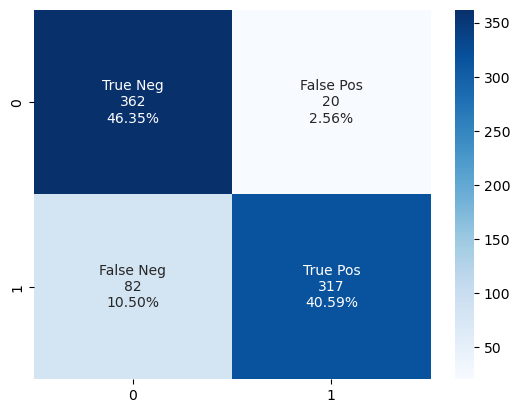

In [48]:
y_pred_XGB = XGB_pipeline.predict(X_test)
print_confusion_matrix(y_test, y_pred_XGB)
metrics_for_model(y_test, y_pred_XGB);

The results from XGB pipeline is not as good as I would have imagined.  
The good thing is, this model have the smallest number of false positives so far...  
If my intension is to keep to the `nintendo` players happy, then this is probably the model to pick...  
It is unlikely to classify `playstation` posts as `nintendo` posts, although it have a higher chance of classifying `nintendo` posts as `playstation`.  
This model offers a high precision, but the trade off is a lower accuracy and a lower f1 socre.
This is likely due to the tunning.  
Let me check the over fitting.  

The accuracy of this inference is: 0.9266730707652898
The precision of this inference is: 0.9931087289433385
The specificty of this inference is: 0.9943960149439601
The recall of this inference is: 0.8549769281476599
The f1 score for this inference is: 0.9188806234502302


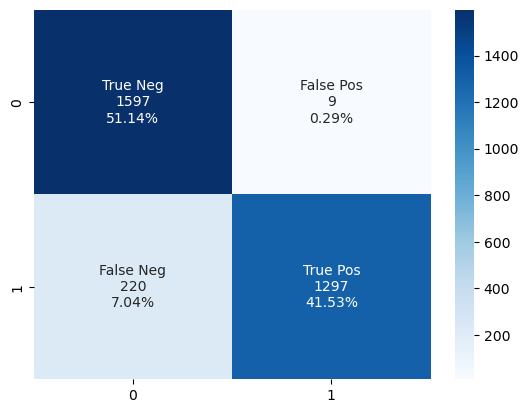

In [49]:
y_pred_XGB_train = XGB_pipeline.predict(X_train)
print_confusion_matrix(y_train, y_pred_XGB_train)
metrics_for_model(y_train, y_pred_XGB_train);

Yes the model is slightly over fitted, just like all other models.  
There's no gross over fitting, and I suspect that it is due to the use of n-grams.  

---
move on to do hyper parameter tunning and see if the performance improves.

In [50]:
rand_search_cv_params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

In [51]:
# Define rand search CV
rand_search = RandomizedSearchCV(xgb_model, param_distributions=rand_search_cv_params, random_state=42, n_iter=200, cv=5, verbose=1, n_jobs=1, return_train_score=True)
# Make pipeline
xgb_rand_search_CV = Pipeline(
    steps=[('tfidf', TfidfVectorizer(min_df=5, ngram_range=(1,3), stop_words=my_stop_words)), 
           ("XGB Rand Search", rand_search)]
) 

In [42]:
xgb_rand_search_CV.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 3),
                                 stop_words={'a', 'about', 'above', 'across',
                                             'after', 'afterwards', 'again',
                                             'against', 'ain', 'all', 'almost',
                                             'alone', 'along', 'already',
                                             'also', 'although', 'always', 'am',
                                             'among', 'amongst', 'amoungst',
                                             'amount', 'an', 'and', 'another',
                                             'any', 'anyhow', 'anyone',
                                             'anything', 'anyway', ...})),
                ('XGB Rand Sear...
                                                         'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fcbcdb57dc0>,
                                                         'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fcbc04064f0>,
                                                         'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fcbc0414250>,
                                                         'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fcbc08278e0>},
                                    random_state=42, return_train_score=True,
                                    verbose=1))])

In [44]:
print("Best scores: ", xgb_rand_search_CV[1].best_score_)

Best scores:  0.866468205128205


In [45]:
print("Best parameters: ", xgb_rand_search_CV[1].best_params_)

Best parameters:  {'colsample_bytree': 0.7982492056533743, 'gamma': 0.05988106590962561, 'learning_rate': 0.2971581842219685, 'max_depth': 5, 'n_estimators': 124, 'subsample': 0.8716409276577959}


In [52]:
XGB_pipeline_final = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5, ngram_range=(1,3), stop_words=my_stop_words)),
    # ('cvec', CountVectorizer(min_df=5, ngram_range=(1,3), stop_words=my_stop_words)),
    ('XGBoost', xgb.XGBClassifier(objective="binary:logistic", 
                                  random_state=42, 
                                  colsample_bytree= 0.7982492056533743, 
                                  gamma= 0.05988106590962561, 
                                  learning_rate= 0.2971581842219685, 
                                  max_depth= 5, 
                                  n_estimators= 124, 
                                  subsample= 0.8716409276577959
                                 )),
])

In [53]:
XGB_pipeline_final.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 3),
                                 stop_words={'a', 'about', 'above', 'across',
                                             'after', 'afterwards', 'again',
                                             'against', 'ain', 'all', 'almost',
                                             'alone', 'along', 'already',
                                             'also', 'although', 'always', 'am',
                                             'among', 'amongst', 'amoungst',
                                             'amount', 'an', 'and', 'another',
                                             'any', 'anyhow', 'anyone',
                                             'anything', 'anyway', ...})),
                ('XGBoost',
                 XG...
                               gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.2971581842219685, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=5, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=124,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=42, ...))])

The accuracy of this inference is: 0.8668373879641486
The precision of this inference is: 0.9300291545189504
The specificty of this inference is: 0.93717277486911
The recall of this inference is: 0.7994987468671679
The f1 score for this inference is: 0.8598382749326146


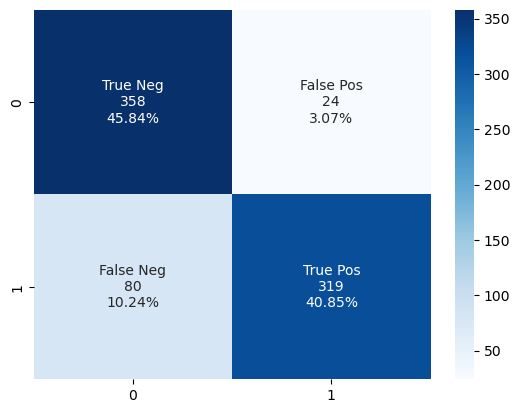

In [54]:
y_pred_XGB_final = XGB_pipeline_final.predict(X_test)
print_confusion_matrix(y_test, y_pred_XGB_final)
metrics_for_model(y_test, y_pred_XGB_final);

In [55]:
df_comb = pd.concat([df_comb, pd.DataFrame(y_pred_XGB_final, columns=['y_XGB'])], axis=1)
df_comb.loc[df_comb['label'] != df_comb['y_XGB']]

,title,label,y_pred_nb,y_prelim_nb,y_pred_nb_2,y_pred_log,y_pred_RF,y_RF_final,y_XGB
4,It’s weird how Sakurai is the only “employee” ...,1,0,0,0,0,0,1,0
5,10 out of 10 best game,0,0,0,0,0,0,0,1
7,Spider Man trailer with 90s theme,0,0,1,0,0,1,1,1
39,For real though I miss the Jak and Daxter game...,0,0,0,0,0,0,0,1
41,WARNING DON'T Upload photos on nintendo live chat,1,0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...
748,Nintendo's next console will lean towards stre...,1,1,0,0,0,0,0,0
749,"As a kid, Nintendo helped me earn my Bear Badge.",1,0,0,0,0,0,0,0
758,This is my drawing of Ratchet & Clank that I f...,0,0,0,0,0,0,0,1
766,Galar Region is based off the UK. Victorian-es...,1,0,1,1,0,0,0,0


In this case, the errors look very similar.  
However, it seems that XGB will classify titles with vague context as `postive`, instead of `negative`, unlike all other previous classifiers.  
This is the result of a different focus, as XGB seems more focused on precision, or making a positive prediction.  

In [56]:
# save the results file as csv in case it is needed for further analysis
df_comb.to_csv('../data/test_results.csv', index_label=False, index=False)

The accuracy of this inference is: 0.9260326609029779
The precision of this inference is: 0.9827327327327328
The specificty of this inference is: 0.9856787048567871
The recall of this inference is: 0.8628872775214239
The f1 score for this inference is: 0.9189189189189189


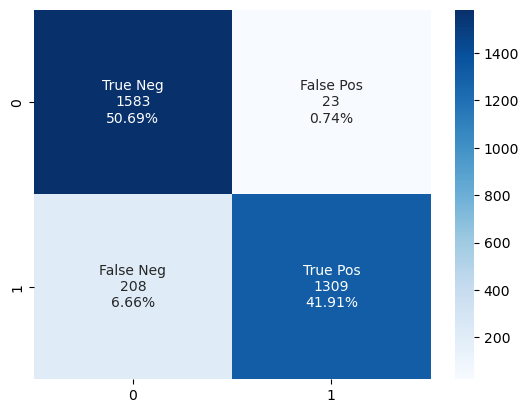

In [57]:
y_pred_XGB_final_train = XGB_pipeline_final.predict(X_train)
print_confusion_matrix(y_train, y_pred_XGB_final_train)
metrics_for_model(y_train, y_pred_XGB_final_train);

The hyper parameter tunning very slightly decreased the precison for the testing set.  
The overall performance as measured by the f1 socre also decreased.  
Once again, the hyper parameter tunning tuned the hyper parameters for the test set, but the same can't be said when it is applied to training set.  
This highlights the problem that the test set, having a different corpus compared to the training set, will result in differnt fitting.  
However, this little exploration is not without its merits.  
Now I can conclude that XGBoost, with the set of hyper parameters I used, is very customised towards making a highly precise prediction, at the sacrifice of accuracy and f1 scores.  

## Conclusions

---
The models tried out are:
1. Navie Bayes
2. Logistic Regression
3. Random Forest
4. XGBoost

A navie baseline model is also built to show how good these models tried when compared against the most naive random guesses.  

After which, pipeline is built with TF-IDF as the first step and the respective algorithms for prediction as the second step.  
Results are analysed using a test set making up 20% of the entire collected data set.  
This test set is not used in training at all.  
The prediction result on the validation set is also reviewed to see if the model can generalise well.  
Predictions made by the models are then saved into a file [test_results.csv](../data/test_results.csv) for comparison. 

The detailed analysis is done for each models above, and just to repeat, models mostly have similar performance.  
It is concluded that the corpus is extremely important in this case.   
There tend to be a higher number of false negatives for all models.   
This is to be expected.  
Looking back to the base line model, it can be seen that there's also more false negatives.  
This is becase my data included more posts from the `playstation` subreddit.  
So this is expected and acceptable.  
The simpler models actually performed exceptionally well.  
Like logistic regression and naive bayes.  

As mentioned in my readme.md, my goal is clear.   
It is to automate the forum control for both nintendo and playstation forums.  
Unfortunately, I can not simply choose nintendo over playstation.  
As such, a model with a good overall performance, in terms of the f1 score, is preferred.   

For ML models, I will probably select the naive bayes based model for production.  
Reason is that is gives good generalisation, have high f1 socre and performs well under most circumstances.  
Should I really want to make the `nintendo` fans happy, I can use the XGBoost model, or the logistic regression model, which focuses on being precise and specific.  
Where:  
`precision = true positives / (true positives + false positives)`  
and  
`specificity = true negatives / (true negatives + false positives)`

However, logistic regression model is also very worthy of a special mention here!  
It is the best perfoming model with the highest f1 socre, and least flase negatives, while being light weight and very very very explainable.  
The only reason it is not selected is that it is highly dependent on the word corpus...  
Also, it is easy to confuse it, as shown below...

In [65]:
for_fun = "help, i am using psvr2 to play mario on my ps which is a ps5 and this will go down in history as wii".join(
" and pokemon are no longer switch exclusive but also on ps and ps4.") 
for_fun_df = pd.DataFrame({'title':[for_fun]})
log_pipeline.predict(for_fun_df['title'])

array([0])

In [70]:
for_fun = "i am using psvr2 to play mario on my ps and this will go down in history as wii".join(
" and pokemon are no longer switch exclusive but also on ps and ps4.")
for_fun_df = pd.DataFrame({'title':[for_fun]})
log_pipeline.predict(for_fun_df['title'])

array([1])

Of course, due to the way the predictions is largely based on tfidf, this problem will persist...   
One other solution is to use use API from chatGPT.  
Or spaCy which I tried but failed.  

Further studies
---

What I can do to further improve this model, is to collect more data using my scrapper, and feed them into my machine learning model.  
Why I want to do this?   
I would want a sample size large enough to capture the population's behaviour in the ideal case.   
This means that the ammount of data and quality of data is very important.  

Another slightly cheating method, is I can do not remove the key give away words like `nintendo` and `playstation`.  
I can also further analyse the predictions that went wrong.  
Which, with all the evidence I have, point towards removal of key give away words.  
Another method I can try, is to use the last kind of ensemble method, stacking!  
This can help to reduce some of the errors by making a majority vote.  
For example, I can select a few models, like XGBoost and Logistic Regression and Naive Bayes and combine them together!  

I can also decrease my minimum document frequency, but I believe this will likely lead to some form of over fitting.  

One thing I think will work is to make a model that predicts on `playstation`.  
So in the case where a title is not from playstation nor nintendo, it can be classified.  
Additionally, there are many many methods and libraries not explored.  
Such as spaCy, a famous NLP library.  

Specific to this topic, I have the document of label vs prediction results.  
That is a very good place to start, after clearing out those correct predictions and wrong predictions due to removal of keywords.  

---


## spaCy & Logistic Regression

spaCy is a Python library used for advanced natural language processing (NLP).    
It is designed to be fast, efficient, and scalable for building applications that require NLP capabilities, such as text classification, entity recognition, and part-of-speech tagging.  
spaCy also includes pre-trained models for several languages, as well as the ability to train custom models on your own data.  
I am only using the spaCy tokenizer and lammatization.  
spaCy also can do a lot more than simple tokenisation.  
The reason I wanted to use this is to evaluate how different tokenisers help with NLP.  
Also, I have tried to make use of classifier in spaCy, but was unable to build my custom model.  

In [1]:
### This part is using a different kernel compared to the previous parts. 

In [20]:
import spacy
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
df = pd.read_csv('../data/combined_df.csv')
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['label'], test_size=0.2, random_state=42)

In [13]:
nlp = spacy.load("en_core_web_sm")
# Load in stop words from pickle
with open("../data/stopwords.pkl", "rb") as f:
    stop_words = pickle.load(f)

# Add stop words to spaCy
for word in stop_words:
    nlp.Defaults.stop_words.add(word)

# Define a function to preprocess the data
def preprocess(text):
    # Tokenize the text
    doc = nlp(text)

    # Lemmatize the tokens and remove stop words and punctuation
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

    # Return the preprocessed text as a string
    return " ".join(tokens)


In [14]:
def print_confusion_matrix(y_actual, y_pred):
    cf_matrix = confusion_matrix(y_actual, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

def metrics_for_model(y_true, y_pred):
    '''find the relavent metrics from confusion metrics
    arg:
        y_true: true value for y
        y_pred: predicted value for y
    out:
        pre: precison score
        rec: recall score
        f1: f1 socre
    '''
    tn, fp, fn, tp =confusion_matrix(y_true, y_pred).ravel()
    acc = (tp+tn)/(tp+fp+tn+fn)
    pre = tp/(tp+fp)
    sp = tn/(tn+fp)
    rec = tp/(tp+fn)
    f1 = 2*(pre*rec)/(pre+rec)
    print(f"The accuracy of this inference is: {acc}")
    print(f"The precision of this inference is: {pre}")
    print(f"The specificty of this inference is: {sp}")
    print(f"The recall of this inference is: {rec}")
    print(f"The f1 score for this inference is: {f1}")
    return pre, rec, f1

In [15]:
# Preprocess the text
X_train = X_train.apply(preprocess)

In [16]:
# Preprocess the test data
X_test = X_test.apply(preprocess)

In [17]:
# Create a pipeline
pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression())
])

In [18]:
# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())])

The accuracy of this inference is: 0.9001280409731114
The precision of this inference is: 0.9190600522193212
The specificty of this inference is: 0.918848167539267
The recall of this inference is: 0.8822055137844611
The f1 score for this inference is: 0.9002557544757033


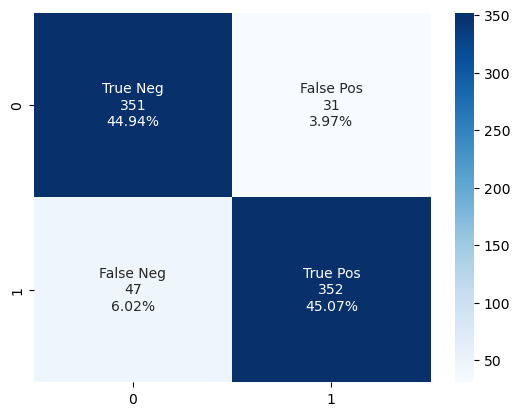

In [21]:
# Make predictions on the testing data
y_pred_sp = pipe.predict(X_test)
print_confusion_matrix(y_test, y_pred_sp)
metrics_for_model(y_test, y_pred_sp);

SpaCy tokeniser generated a smaller portion of `false negative` and more `true postive`.  
This means that some titles previously wrongly classified as negative are now correctly classified.  
SpaCy's tokenizer is designed to handle a wide range of text types, including informal language, typos, and variations in spelling and punctuation.   
It's also very good at handling compound words, contractions, and other complex expressions.  
This is indeed very useful and does a much better job at tokenizing my documents.  
Let me take a look at the errors!  

In [22]:
df_comb = pd.read_csv('../data/test_results.csv')
df_comb = pd.concat([df_comb, pd.DataFrame(y_pred_sp, columns=['y_sp'])], axis=1)
df_comb.loc[df_comb['label'] != df_comb['y_sp']]

,title,label,y_pred_nb,y_prelim_nb,y_pred_nb_2,y_pred_RF,y_RF_final,y_XGB,y_sp
41,WARNING DON'T Upload photos on nintendo live chat,1,0,1,1,0,0,0,0
54,PSA for those looking at the legend of dragoon...,0,0,1,0,1,1,1,1
69,You can buy a brand new sealed copy of LarryBo...,1,0,0,0,1,1,1,0
77,How simple texture compression can start a 20-...,1,0,0,0,0,0,0,0
85,Received this copy of Doom Eternal...,0,1,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...
747,Tis the season on the Starfall Islands. You ca...,1,0,0,0,0,0,0,0
749,"As a kid, Nintendo helped me earn my Bear Badge.",1,0,0,0,0,0,0,0
762,You can't convert replays to video unless you ...,1,1,0,0,1,1,1,0
766,Galar Region is based off the UK. Victorian-es...,1,0,1,1,0,0,0,0


In [27]:
nb_pipeline_sp = Pipeline([
    # ('stem_lemmatize', StemLemmatizeTransformer()),
    ('tfidf', TfidfVectorizer(min_df=5, ngram_range=(1,3), stop_words=list(stop_words))),
    ('clf', MultinomialNB()),
])

The accuracy of this inference is: 0.8758002560819462
The precision of this inference is: 0.8994708994708994
The specificty of this inference is: 0.900523560209424
The recall of this inference is: 0.8521303258145363
The f1 score for this inference is: 0.8751608751608752


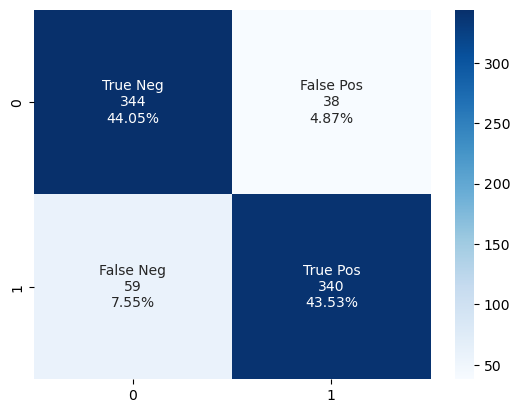

In [28]:
nb_pipeline_sp.fit(X_train, y_train)
y_pred_nb_sp = nb_pipeline_sp.predict(X_test)
print_confusion_matrix(y_test, y_pred_nb_sp)
metrics_for_model(y_test, y_pred_nb_sp);

The accuracy of this inference is: 0.9785462696125521
The precision of this inference is: 0.9979395604395604
The specificty of this inference is: 0.99813200498132
The recall of this inference is: 0.957811470006592
The f1 score for this inference is: 0.9774638412378068


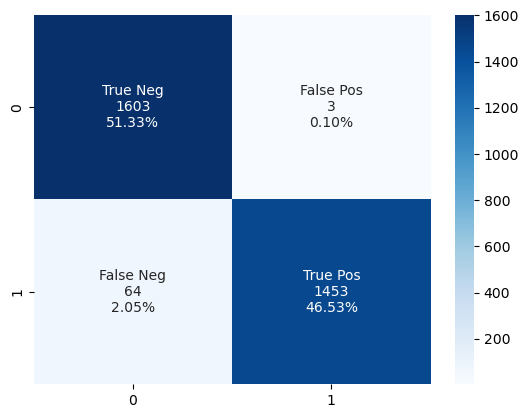

In [39]:
# check over fitting on the training data
y_pred_sp_train = pipe.predict(X_train)
print_confusion_matrix(y_train, y_pred_sp_train)
metrics_for_model(y_train, y_pred_sp_train);

### spaCy classifier

In [43]:
from spacy.pipeline.textcat import single_label_cnn_config

nlp = spacy.load("en_core_web_sm")
if "textcat" not in nlp.pipe_names:
     nlp.add_pipe('textcat', config=single_label_cnn_config, last=True)
textcat = nlp.get_pipe('textcat')
textcat.add_label("pos")
textcat.add_label("neg")

ValueError: [E962] Received incorrect config for pipe 'textcat'. Expected dict, got: <class 'str'>.

In [41]:

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Define the text classification model
textcat = nlp.create_pipe("textcat", config={"exclusive_classes": True})
textcat.add_label("POSITIVE")
textcat.add_label("NEGATIVE")
nlp.add_pipe(textcat)

ConfigValidationError: 

Config validation error

textcat -> exclusive_classes   extra fields not permitted

{'nlp': <spacy.lang.en.English object at 0x7f8b55c05720>, 'name': 'textcat', 'exclusive_classes': True, 'model': {'@architectures': 'spacy.TextCatEnsemble.v2', 'linear_model': {'@architectures': 'spacy.TextCatBOW.v2', 'exclusive_classes': True, 'ngram_size': 1, 'no_output_layer': False}, 'tok2vec': {'@architectures': 'spacy.Tok2Vec.v2', 'embed': {'@architectures': 'spacy.MultiHashEmbed.v2', 'width': 64, 'rows': [2000, 2000, 1000, 1000, 1000, 1000], 'attrs': ['ORTH', 'LOWER', 'PREFIX', 'SUFFIX', 'SHAPE', 'ID'], 'include_static_vectors': False}, 'encode': {'@architectures': 'spacy.MaxoutWindowEncoder.v2', 'width': 64, 'window_size': 1, 'maxout_pieces': 3, 'depth': 2}}}, 'scorer': {'@scorers': 'spacy.textcat_scorer.v1'}, 'threshold': 0.5, '@factories': 'textcat'}

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import spacy

# Load the spaCy model and define the preprocessing function
nlp = spacy.load("en_core_web_sm")
def preprocess(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

# Define the text classification model
textcat = nlp.create_pipe("textcat", config={"exclusive_classes": True})
textcat.add_label("POSITIVE")
textcat.add_label("NEGATIVE")
nlp.add_pipe(textcat)

# Create the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=preprocess)),
    ('clf', textcat)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_test_2 = pipeline.predict(X_test)


ConfigValidationError: 

Config validation error

textcat -> exclusive_classes   extra fields not permitted

{'nlp': <spacy.lang.en.English object at 0x7f8b55c07310>, 'name': 'textcat', 'exclusive_classes': True, 'model': {'@architectures': 'spacy.TextCatEnsemble.v2', 'linear_model': {'@architectures': 'spacy.TextCatBOW.v2', 'exclusive_classes': True, 'ngram_size': 1, 'no_output_layer': False}, 'tok2vec': {'@architectures': 'spacy.Tok2Vec.v2', 'embed': {'@architectures': 'spacy.MultiHashEmbed.v2', 'width': 64, 'rows': [2000, 2000, 1000, 1000, 1000, 1000], 'attrs': ['ORTH', 'LOWER', 'PREFIX', 'SUFFIX', 'SHAPE', 'ID'], 'include_static_vectors': False}, 'encode': {'@architectures': 'spacy.MaxoutWindowEncoder.v2', 'width': 64, 'window_size': 1, 'maxout_pieces': 3, 'depth': 2}}}, 'scorer': {'@scorers': 'spacy.textcat_scorer.v1'}, 'threshold': 0.5, '@factories': 'textcat'}

In [19]:
# Make predictions on the testing data
y_pred = pipe.predict(X_test)

# Calculate the accuracy of the predictions
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9244558258642765


In [ ]:
report_best_scores(search.cv_results_, 1)

In [6]:

class StemLemmaTfidfLDA(BaseEstimator, TransformerMixin):
    def __init__(self, stop_words='english', max_features=5000, n_components=10, max_df=0.95, min_df=2):
        self.stemmer = SnowballStemmer('english')
        self.lemmatizer = WordNetLemmatizer()
        self.tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=max_features)
        self.lda_model = LatentDirichletAllocation(n_components=n_components, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
        self.max_df = max_df
        self.min_df = min_df
    
    def stem_and_lemmatize(self, document):
        return [self.stemmer.stem(self.lemmatizer.lemmatize(token)) for token in document.split()]

    def fit(self, X, y=None):
        X_stemmed_lemmatized = [' '.join(self.stem_and_lemmatize(document)) for document in X]
        X_tfidf = self.tfidf_vectorizer.fit_transform(X_stemmed_lemmatized)
        self.lda_model.fit(X_tfidf)
        return self

    def transform(self, X):
        X_stemmed_lemmatized = [' '.join(self.stem_and_lemmatize(document)) for document in X]
        X_tfidf = self.tfidf_vectorizer.transform(X_stemmed_lemmatized)
        X_lda = self.lda_model.transform(X_tfidf)
        return X_lda


In [23]:
def metrics_for_model(y_true, y_pred):
    '''find the relavent metrics from confusion metrics
    arg:
        y_true: true value for y
        y_pred: predicted value for y
    out:
        pre: precison score
        rec: recall score
        f1: f1 socre
    '''
    tn, fp, fn, tp =confusion_matrix(y_true, y_pred).ravel()
    pre = tp/(tp+fp)
    rec = tp/(tp+fn)
    f1 = 2*(pre*rec)/(pre+rec)
    print(f"The recall of this inference is: {rec}")
    print(f"The precision of this inference is: {pre}")
    print(f"The f1 score for this inference is: {f1}")
    return pre, rec, f1

In [24]:
metrics_for_model(df['label'], df['pred']);

The recall of this inference is: 0.9525052192066806
The precision of this inference is: 0.9769807280513919
The f1 score for this inference is: 0.9645877378435519


In [ ]:
# dnn based idea generator that make weak links.
# then use GAN to determine if the idea is feasible.

In [ ]:
import numpy as np
import spacy
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from gensim.models import KeyedVectors


class StemLemmatizeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    
    def stem(self, word):
        stemmer = SnowballStemmer("english")
        return stemmer.stem(word)

    def lemmatize(self, doc):
        doc = self.nlp(doc)
        return [token.lemma_ for token in doc]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.apply(lambda x: " ".join([self.stem(w) for w in x.split()]))
        X = X.apply(lambda x: " ".join(self.lemmatize(x)))
        return X


class WordEmbeddingsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, embeddings_file):
        self.embeddings_file = embeddings_file

    def fit(self, X, y=None):
        self.word_vectors = KeyedVectors.load_word2vec_format(self.embeddings_file, binary=False)
        return self

    def transform(self, X):
        X_embedded = []
        for sentence in X:
            embedded_sentence = []
            for word in sentence.split():
                if word in self.word_vectors:
                    embedded_sentence.append(self.word_vectors[word])
            if len(embedded_sentence) > 0:
                X_embedded.append(np.mean(embedded_sentence, axis=0))
            else:
                X_embedded.append(np.zeros(100))
        return np.array(X_embedded)

pipeline = Pipeline([
    ('stem_lemmatize', StemLemmatizeTransformer()),
    ('tfidf', TfidfVectorizer()),
    ('embeddings', WordEmbeddingsTransformer(embeddings_file='/path/to/glove.6B.100d.txt'))
])
